Methods

* Load & Merge the Datasets
* Identify Healthcare Access Variables (e.g., Distance, Facility Type, Visits)
* Compare Malaria Prevalence by Healthcare Access Levels
* Statistical Testing (T-test, ANOVA)
* Regression Analysis for Healthcare Impact on Malaria
* Visualizing the Trends

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import geopandas as gpd
import folium
from folium.plugins import HeatMap

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [109]:
df_main  = pd.read_csv('Malaria screener.csv')
df_age  = pd.read_csv('Malaria screener age.csv')

In [110]:
# Merge datasets (if necessary)
if 'ID' in df_main.columns and 'ID' in df_age.columns:
    df = pd.merge(df_main, df_age, on='ID', how='inner')  # Merge on ID
else:
    df = pd.concat([df_main, df_age], axis=1)  # Merge by column order

In [111]:
# Select relevant columns
selected_columns = ['Global_Human_Footprint', 'Travel_Times', 'Type of place of residence','Use of internet', 'Owns a mobile telephone','Religion','Type of toilet facility','Source of drinking water','Number of visits','Malaria_Prevalence_2020']

# Check for missing values in the selected columns
missing_values = df[selected_columns].isnull().sum()
df = df[selected_columns].dropna()

# Display summary of the cleaned dataset
df.describe(), missing_values

(       Global_Human_Footprint  Travel_Times  Type of place of residence  \
 count              567.000000    567.000000                  567.000000   
 mean                37.576512     26.266518                    1.611993   
 std                 14.072831     45.689079                    0.487726   
 min                 18.897411      0.000000                    1.000000   
 25%                 28.247476      4.171875                    1.000000   
 50%                 33.688377     13.456055                    2.000000   
 75%                 42.500610     30.802246                    2.000000   
 max                 90.235657    571.871094                    2.000000   
 
        Use of internet  Owns a mobile telephone    Religion  \
 count        567.00000               567.000000  567.000000   
 mean           0.33157                 0.684303    1.523810   
 std            0.50381                 0.465203    0.563038   
 min            0.00000                 0.000000    1.0000

In [87]:
# Malaria Prevalence by Healthcare Access
for col in df:
    grouped_data = df.groupby(col)['Malaria_Prevalence_2020'].agg(['mean', 'count'])
    print(f"\n📊 Malaria Prevalence by {col}:\n", grouped_data)



📊 Malaria Prevalence by Global_Human_Footprint:
                             mean  count
Global_Human_Footprint                 
18.897411               0.257360      1
19.810881               0.349574      1
20.186335               0.223989      1
21.000000               0.272979     17
21.163387               0.256048      1
...                          ...    ...
85.805618               0.166026      1
86.773674               0.155367      1
88.488426               0.173962      1
88.754105               0.182852      1
90.235657               0.207415      1

[528 rows x 2 columns]

📊 Malaria Prevalence by Travel_Times:
                   mean  count
Travel_Times                 
0.000000      0.232378     13
0.002930      0.171464      1
0.013672      0.158014      1
0.034180      0.294406      2
0.040039      0.542671      1
...                ...    ...
210.089905    0.266462      1
217.197266    0.079607      1
338.918945    0.320930      1
481.361328    0.308700      1
571.87

In [88]:
 # Perform ANOVA Test if More than Two Categories
unique_values = df[col].nunique()
if unique_values > 2:
    groups = [df[df[col] == value]['Malaria_Prevalence_2020'] for value in df[col].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"\n🔬 ANOVA Results for {col}: F-statistic = {f_stat:.4f}, P-value = {p_value:.4e}")


🔬 ANOVA Results for Malaria_Prevalence_2020: F-statistic = inf, P-value = 0.0000e+00


In [89]:
 # Perform T-test if Only Two Groups
if unique_values == 2:
    group1 = df[df[col] == df[col].unique()[0]]['Malaria_Prevalence']
    group2 = df[df[col] == df[col].unique()[1]]['Malaria_Prevalence']
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
    print(f"\n🎯 T-Test for {col}: T-statistic = {t_stat:.4f}, P-value = {p_value:.4e}")

In [90]:
# Create Age Groups
Travel_bins = [0, 100, 200, 300, 400, 500, 600]
Travel_labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '501+']
df['Travel_Group'] = pd.cut(df['Travel_Times'], bins=Travel_bins, labels=Travel_labels, right=False)

In [91]:
# Compute mean malaria prevalence for each group
grouped_data = df.groupby(['Travel_Group', 'Type of place of residence','Number of visits'])['Malaria_Prevalence_2020'].mean().reset_index()
grouped_data.rename(columns={'Malaria_Prevalence_2020': 'Average_Prevalence'}, inplace=True)
print("\nSummary Statistics:\n", grouped_data)


Summary Statistics:
    Travel_Group  Type of place of residence  Number of visits  \
0         0-100                           1                 1   
1         0-100                           1                 2   
2         0-100                           1                 3   
3         0-100                           1                 4   
4         0-100                           1                 5   
5         0-100                           2                 1   
6         0-100                           2                 2   
7         0-100                           2                 3   
8         0-100                           2                 4   
9         0-100                           2                 5   
10      101-200                           1                 1   
11      101-200                           1                 2   
12      101-200                           1                 3   
13      101-200                           1                 4   
14 

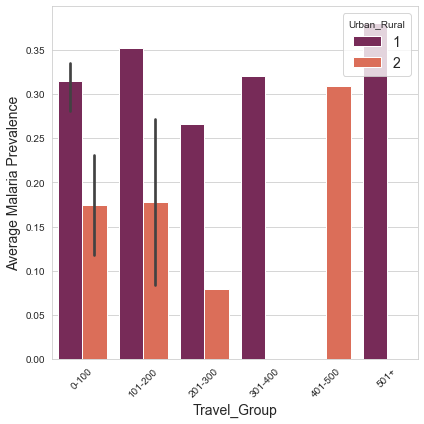

In [95]:
# Visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
sns.barplot(data=grouped_data, y='Average_Prevalence', x='Travel_Group', hue= 'Type of place of residence', palette='rocket')
#plt.title('Malaria Prevalence Trends')
plt.xlabel('Travel_Group', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

  Malaria Prevalence Trends

* The bar and line plots reveal travel groups with higher prevalence.
* Differences between urban and rural prevalence are visualized.
* 1 = urban; 2 = rural

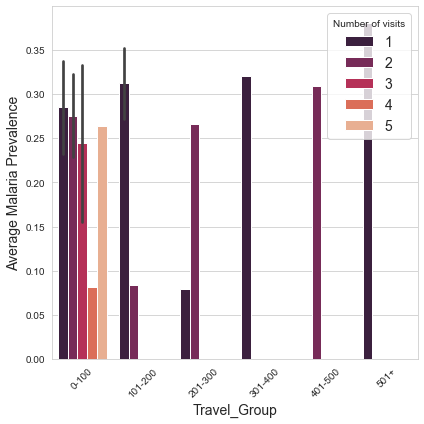

In [94]:
# Visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
sns.barplot(data=grouped_data, y='Average_Prevalence', x='Travel_Group', hue= 'Number of visits', palette='rocket')
#plt.title('Malaria Prevalence Trends')
plt.xlabel('Travel_Group', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Number of visits', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Malaria Prevalence Trends

* The bar and line plots reveal travel groups with higher prevalence.
* Differences among number of visits prevalence are visualized.

In [123]:
# Encode Categorical Variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [124]:
target_name = 'Type of place of residence'

In [125]:
# ✅ Convert {1,2} to {0,1} for Binary Classification
if set(df[target_name].unique()) == {1, 2}:
    df[target_name] = df[target_name] - 1  # Convert to {0,1}

# Convert Target to Integer (if needed)
df[target_name] = df[target_name].astype(int)

In [126]:
target_name = 'Type of place of residence'
robust_scaler = RobustScaler()
x = df.drop('Type of place of residence', axis=1)
X = robust_scaler.fit_transform(x)
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=123)

In [127]:
# Standardize Numerical Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

* Accuracy Score: Indicates how well the model predicts malaria risk.
* Classification Report: Shows precision, recall, and F1-score for malaria prediction.
* AUC-ROC Curve: Measures model performance in distinguishing malaria cases.

In [102]:
# Train a Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

print("\n🎯 Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n🔬 Classification Report:\n", classification_report(y_test, y_pred))


🎯 Model Performance:
Accuracy: 0.9298

🔬 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        46
           1       0.94      0.94      0.94        68

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



In [103]:
# AUC-ROC Curve
if len(df[target_name].unique()) == 2:
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

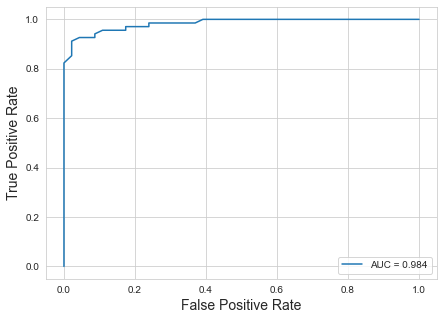

In [104]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
#plt.title("ROC Curve - Malaria Risk Prediction")
plt.legend()
plt.show()

ROC Curve - Malaria Risk Prediction

Feature Importance

* Distance to Healthcare Facility: Higher importance suggests malaria risk is influenced by facility accessibility.
* Facility Type: Determines if healthcare quality impacts malaria rates.
* Number of Visits to a Health Center: Indicates preventive healthcare access.

In [117]:
# Feature Importance
features = x.columns
feature_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
print("\n📌 Feature Importance:\n", feature_importance)


📌 Feature Importance:
 Type of toilet facility     0.293304
Use of internet             0.169674
Malaria_Prevalence_2020     0.158091
Source of drinking water    0.140816
Travel_Times                0.088236
Global_Human_Footprint      0.071165
Religion                    0.050937
Owns a mobile telephone     0.023754
Number of visits            0.004023
dtype: float64


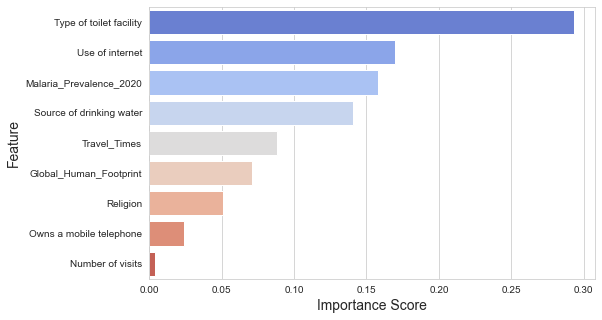

In [118]:
# Visualize Feature Importance
plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='coolwarm')
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
#plt.title("Feature Importance in Malaria Risk Prediction")
plt.show()

Feature Importance in Malaria Risk Prediction

In [128]:
# Train XGBoost Model (Alternative)
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n🚀 XGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\n🔬 Classification Report:\n", classification_report(y_test, y_pred))


🚀 XGBoost Model Performance:
Accuracy: 0.9298

🔬 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        46
           1       0.94      0.94      0.94        68

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114

